# GPT2 





In [1]:
!pip install transformers 
!pip install datasets 

     |████████████████████████████████| 3.8 MB 14.9 MB/s 
     |████████████████████████████████| 895 kB 39.2 MB/s 
     |████████████████████████████████| 6.5 MB 44.0 MB/s 
     |████████████████████████████████| 596 kB 43.9 MB/s 
     |████████████████████████████████| 67 kB 3.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 312 kB 12.8 MB/s 
     |████████████████████████████████| 1.1 MB 22.3 MB/s 
     |████████████████████████████████| 212 kB 53.3 MB/s 
     |████████████████████████████████| 134 kB 59.4 MB/s 
     |████████████████████████████████| 127 kB 60.9 MB/s 
     |████████████████████████████████| 144 kB 36.5 MB/s 
     |████████████████████████████████| 271 kB 60.6 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urll

## Load the **ELI5**(Explain Like I'm Five of Reddit) Dataset!
The ELI5 dataset is an English-language dataset of questions and answers gathered from three subreddits where users ask factual questions requiring paragraph-length or longer answers. The dataset was created to support the task of open-domain long form abstractive question answering, and covers questions about general topics in its r/explainlikeimfive subset, science in it r/askscience subset, and History in its r/AskHistorians subset.

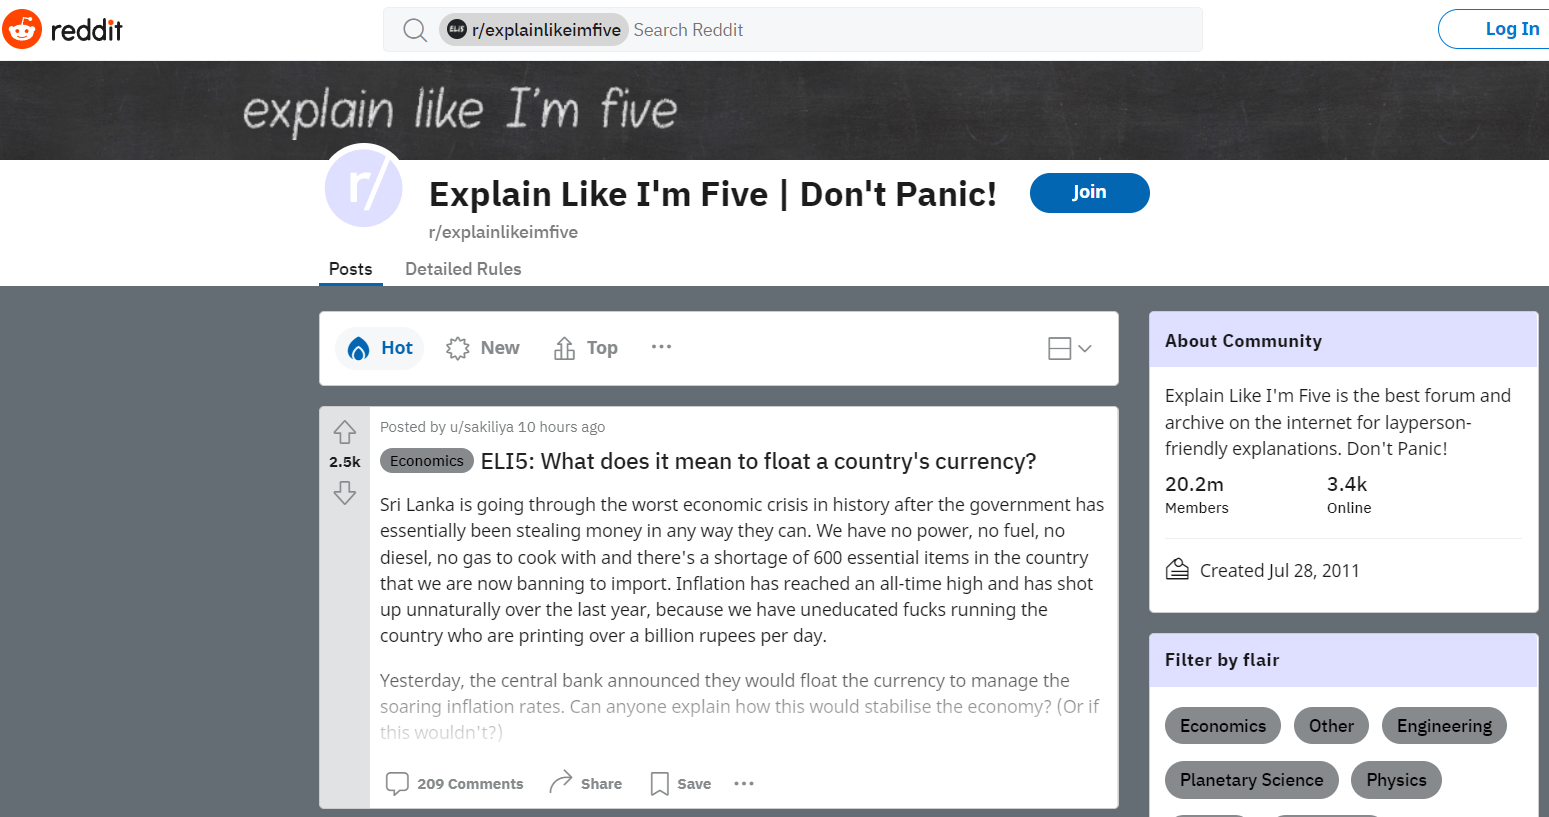

In [4]:
from datasets import load_dataset

eli5 = load_dataset("eli5", split="train_asks[:5000]")

eli5

Reusing dataset eli5 (/root/.cache/huggingface/datasets/eli5/LFQA_reddit/1.0.0/17574e5502a10f41bbd17beba83e22475b499fa62caa1384a3d093fc856fe6fa)


Dataset({
    features: ['q_id', 'title', 'selftext', 'document', 'subreddit', 'answers', 'title_urls', 'selftext_urls', 'answers_urls'],
    num_rows: 5000
})

In [5]:
eli5 = eli5.train_test_split(test_size=0.2)

In [6]:
eli5["train"][0]

{'answers': {'a_id': ['cdbqqkq'],
  'score': [6],
  'text': ["The term of parallel evolution is used inconsistently in the literature. Some people use parallel evolution to describe two populations of the same organism evolving the same adaptations independently. The term is also used to describe independent evolution of a homologous structures in two separate species to create a similar adaptation. Since the second usage of the term is more consistent with the common usage of the term convergent evolution (which is typically taken to mean usage of non-homologous structures in two separate species to create a similar adaptation), it is the usage I prefer. I would refer to the former case (two populations of the same organism evolving the same adaptations independently) as deterministic evolution to better contrast it with the possibility adaptive evolution may occur stochastically. \n\nEnvironmental similarity is only of importance in the first usage of the term. A deterministic evolut

## Preprocess

In [2]:
from transformers import AutoTokenizer 

tokenizer = AutoTokenizer.from_pretrained("distilgpt2")

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [7]:
eli5 = eli5.flatten() 

eli5["train"][0]

{'answers.a_id': ['cdbqqkq'],
 'answers.score': [6],
 'answers.text': ["The term of parallel evolution is used inconsistently in the literature. Some people use parallel evolution to describe two populations of the same organism evolving the same adaptations independently. The term is also used to describe independent evolution of a homologous structures in two separate species to create a similar adaptation. Since the second usage of the term is more consistent with the common usage of the term convergent evolution (which is typically taken to mean usage of non-homologous structures in two separate species to create a similar adaptation), it is the usage I prefer. I would refer to the former case (two populations of the same organism evolving the same adaptations independently) as deterministic evolution to better contrast it with the possibility adaptive evolution may occur stochastically. \n\nEnvironmental similarity is only of importance in the first usage of the term. A determinis

In [16]:
def preprocess_function(examples):
  return tokenizer([" ".join(x) for x in examples["answers.text"]], truncation=True)

tokenized_eli5 = eli5.map(preprocess_function, batched=True, num_proc=4, remove_columns=eli5["train"].column_names,)

In [20]:
block_size = 128 

def group_texts(examples):
  concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
  total_length = len(concatenated_examples[list(examples.keys())[0]])
  result = { 
      k: [t[i: i + block_size] for i in range(0, total_length, block_size)]
      for k,t in concatenated_examples.items()
  }
  result["labels"] = result["input_ids"].copy() 
  return result

In [21]:
lm_dataset = tokenized_eli5.map(group_texts, batched=True, num_proc=4)

In [22]:
from transformers import DataCollatorForLanguageModeling 

tokenizer.pad_token = tokenizer.eos_token 
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [ ]:
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer 

model = AutoModelForCausalLM.from_pretrained("distilgpt2")

training_args = TrainingArguments(output_dir="./results", evaluation_strategy="epoch", learning_rate=2e-5, weight_decay=0.01,)

trainer = Trainer(model=model, args=training_args, train_dataset=lm_dataset["train"], eval_dataset=lm_dataset["test"], data_collator=data_collator,)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8561
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3213


Epoch,Training Loss,Validation Loss
